## Problem Statement

Given images, how to go about comparing the similarity of images

**Studies**:
- https://tech.okcupid.com/evaluating-perceptual-image-hashes-okcupid/
- https://content-blockchain.org/research/testing-different-image-hash-functions/

In [134]:
from PIL import Image
import matplotlib.pyplot as plt
import textwrap
import imagehash
import requests
import os

def get_image(url):
    """
        Returns an image object converted to grayscale, 
        creating smaller thumbnails while preserving aspect ratio
    """
    size = 128, 128
    im = Image.open(requests.get(url, stream=True).raw).convert('LA')
    im.thumbnail(size)
    return im

def display_images(
    images, labels,
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)

        if len(labels) > 0:
            title=labels[i]
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size); 

In [135]:
dress_url = "https://images-na.ssl-images-amazon.com/images/I/614jS1ShIWL._AC_UY445_.jpg"
diff_dress_url = "https://images-na.ssl-images-amazon.com/images/I/51rBSc1aY6L._UL1280_.jpg"
similar_dress_url = "https://cdn.shopify.com/s/files/1/2620/2040/products/68109u_450x.jpg?v=1574139794"

In [136]:
main_image, exact_same_image = get_image(dress_url), get_image(dress_url)
similar_image, different_image = get_image(similar_dress_url), get_image(diff_dress_url)

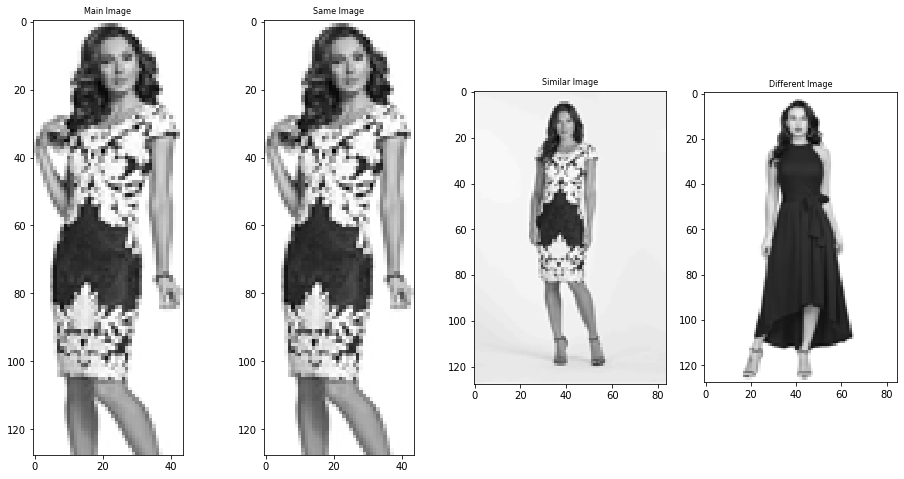

In [137]:
display_images([main_image, exact_same_image, similar_image, different_image], ["Main Image", "Same Image", "Similar Image", "Different Image"])

In [121]:
# hash size could be specified depending on how much granularity we would like, increasing it will increase the storage requirements, as well as, hash comparison time
main_hash = imagehash.phash(main_image)
exact_same_hash = imagehash.phash(exact_same_image)
similar_hash = imagehash.phash(similar_image)
different_hash = imagehash.phash(different_image)

In [122]:
print("Main hash: ", main_hash)
print("Exact same hash: ", exact_same_hash)
print("Images are similar:", main_hash == exact_same_hash, "Difference:", main_hash - exact_same_hash)

Main hash:  b863e1277984c736
Exact same hash:  b863e1277984c736
Images are similar: True Difference: 0


In [123]:
print("Main hash: ", main_hash)
print("Similar hash: ", similar_hash)
print("Images are similar:", main_hash == similar_hash, "Difference:", main_hash - similar_hash)

Main hash:  b863e1277984c736
Similar hash:  b333cfc63230cccc
Images are similar: False Difference: 30


In [124]:
print("Main hash: ", main_hash)
print("Different hash: ", different_hash)
print("Images are similar:", main_hash == different_hash, "Difference:", main_hash - different_hash)

Main hash:  b863e1277984c736
Different hash:  e1929a698e699679
Images are similar: False Difference: 40


## Building ML Pipeline
The images can be stored in S3 buckets through an API call from an ecommerce site. We can setup a trigger on S3 image creation, the trigger will start a AWS Lambda function that will generate and store the imagehash. 

**Simple solution:** Store the image hashes as a bitstring is Postgres. We can create a separate tables for saving the Hamming distance between two image hashes. An initial performance cost will be incurred since adding a new image to the dataset will involve calculating its distance to all other existing image hashes in the databaset. There will also be an additional cost to saving the distances, but lookup will be a simple SQL query. 

If our main use case is to compare image hashes with the images of a single ecommerce site, this solution might suffice. But as the number of existing images that we need to compare (for example, we're comparing images between multiple ecommerce sites), then this solution will not scale well. 


**Nuanced scalable solution:** Instead of storing the hashes in the database, we can keep track of an in memory [BK-Tree](https://en.wikipedia.org/wiki/BK-tree) that keeps the distance between nodes. The search could be performed with an algorithm, such as [Nearest Neighbor Search](https://en.wikipedia.org/wiki/Nearest_neighbor_search) performance will be O(log N), where N is the number of images. Adding a new image is also great in terms of performance and this solution will save in storage as well.